In [1]:
import sys
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install tqdm

  Using cached scipy-1.4.1-cp38-cp38-manylinux1_x86_64.whl (26.0 MB)
  Using cached numpy-1.18.4-cp38-cp38-manylinux1_x86_64.whl (20.7 MB)
  Using cached matplotlib-3.2.1-cp38-cp38-manylinux1_x86_64.whl (12.4 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.2.0-cp38-cp38-manylinux1_x86_64.whl (92 kB)
  Using cached seaborn-0.10.1-py3-none-any.whl (215 kB)
  Using cached pandas-1.0.3-cp38-cp38-manylinux1_x86_64.whl (10.0 MB)
  Using cached pytz-2020.1-py2.py3-none-any.whl (510 kB)
  Using cached tqdm-4.46.0-py2.py3-none-any.whl (63 kB)


In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import chain
import random
from tqdm import tqdm

### parameter selection
* reference here: https://www.notion.so/yanhong/Model-inputs-and-assumptions-f1228f7d6015454eab2ffb9cb4668d15
* Note: $\mu$ is not the standard gamma parameter, a = $k$, scale = $\theta$, and $\mu = k\theta$
* infection probabilty given a S - I connection in this model is 1, since we assume that when living together in a tent or standing jammed in a line for an hour has almost certian probability of infection
* i.e. a symptomatic person will infect two people when standing in line, asymptomatic person will infect one person
* TODO: switching between household member who collects food when a single family member becomes symptomatic

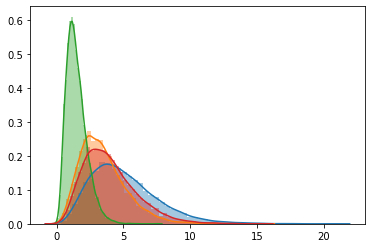

In [3]:
# infection probabilty
beta = 1
# Relative infectiousness of asymptomatic cases
f = 0.5
# Probability of becoming a symptomatic case, if infected, for age group i
yi = 0.5
# Duration of asymptomatic infectiousness in days
dS = scipy.stats.gamma(4, scale=5/4)
# Duration of symptomatic infectiousness in days
dC = scipy.stats.gamma(4, scale=3.5/4)
# Duration of pre-symptomatic infectiousness in days
dP = scipy.stats.gamma(4, scale=1.5/4)
# Latent periods in days
dE = scipy.stats.gamma(4, scale=4/4)
# Note: time step is days
for i in [dS, dC, dP, dE]:
    sns.distplot(i.rvs(10000))

### Modeling a refugee camp
* average amount of people in a tent / household: 4
* single tent member collects food
* three times per day needs to collect food
* comes into contact with two persons per food collection round

In [4]:
people_per_tent = 4
n_population = 19999
tents = round(n_population / people_per_tent)
# slightly adjust n_population to match the amount of tents
n_population = tents * people_per_tent
#now simulate the daily random connections from a food queue: here were making an assumption that it will be different people, will always be 2 different people per food collection, it can be the same between food collections
daily_random_contacts = 2 * 3

def create_population_df(people_per_tent, n_population):
    tents = round(n_population / people_per_tent)
    # create population data frame where as much as possible it loaded
    population_df = pd.DataFrame()
    population_df['is_food_collector'] = tents * ([1] + [0] * (people_per_tent-1))
    population_df['is_food_collector'] = population_df['is_food_collector'].astype(bool)
    population_df['is_symptomatic'] = scipy.stats.bernoulli.rvs(yi, size=n_population)
    population_df['is_symptomatic'] = population_df['is_symptomatic'].astype(bool)
    population_df['dE'] = dE.rvs(n_population)
    population_df['dP'] = dP.rvs(n_population)
    # days of infectiousness  
    population_df['dI'] = population_df['is_symptomatic'] * dS.rvs(n_population) + (1 - population_df['is_symptomatic']) * dS.rvs(n_population)
    population_df['t_latent'] = np.nan
    population_df['t_presymptomatic_infectious'] = np.nan
    population_df['t_infectious'] = np.nan
    population_df['t_postinfectious'] = np.nan
    return population_df

population_df = create_population_df(people_per_tent, n_population)
population_df

,is_food_collector,is_symptomatic,dE,dP,dI,t_latent,t_presymptomatic_infectious,t_infectious,t_postinfectious
0,True,False,2.739859,1.839592,3.075340,NaN,NaN,NaN,NaN
1,False,True,4.751808,0.768349,7.446233,NaN,NaN,NaN,NaN
2,False,False,4.401779,2.017708,5.301039,NaN,NaN,NaN,NaN
3,False,False,2.644983,1.147478,1.972095,NaN,NaN,NaN,NaN
4,True,False,3.664274,1.088631,4.593841,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
19995,False,True,4.391155,0.809042,3.641295,NaN,NaN,NaN,NaN
19996,True,False,7.568775,0.568836,5.743010,NaN,NaN,NaN,NaN
19997,False,False,2.910570,1.348149,6.868184,NaN,NaN,NaN,NaN
19998,False,True,4.625661,3.291867,2.877881,NaN,NaN,NaN,NaN


In [5]:
# create adjacency matrix

base_tent_connections = np.array(range(people_per_tent))
tent_connections = [people_per_tent * [base_tent_connections + people_per_tent * tent] for tent in range(tents)]
tent_connections = list(chain.from_iterable(tent_connections))
tent_adj_matrix = np.zeros(shape=(n_population, n_population))
for i in range(n_population):
    for j in tent_connections[i]:
        if i != j:
            tent_adj_matrix[i, j] = 1

# now create the adjacency matrix from the queue. These are random connections to any 6 of the other food collectors
adj_matrix = tent_adj_matrix
food_collector_indices = np.where(population_df['is_food_collector'])[0]

def add_daily_random_connections(adj_matrix, food_collector_indices, daily_random_contacts):
    n_food_collectors = len(food_collector_indices)
    for i in food_collector_indices:
        for j in food_collector_indices:
            if i != j:
                adj_matrix[i,j] = daily_random_contacts / n_food_collectors
    return adj_matrix
        

adj_matrix = add_daily_random_connections(adj_matrix, food_collector_indices, daily_random_contacts)

def apply_relative_infectiousness_of_asymptomatic(adj_matrix, population_df, f):
    asymptomatic_indices = np.where(population_df['is_symptomatic'])[0]
    for i in asymptomatic_indices:
        adj_matrix[:,i] = adj_matrix[:,i] * f
    return(adj_matrix)
    
adj_matrix = apply_relative_infectiousness_of_asymptomatic(adj_matrix, population_df, f)
    
# finally apply beta
adj_matrix = adj_matrix * beta

pd.DataFrame(adj_matrix)

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,0.0000,0.5,1.0,1.0,0.0012,0.0,0.0,0.0,0.0012,0.0,...,0.0,0.0,0.0006,0.0,0.0,0.0,0.0012,0.0,0.0,0.0
1,1.0000,0.0,1.0,1.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
2,1.0000,0.5,0.0,1.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
3,1.0000,0.5,1.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
4,0.0012,0.0,0.0,0.0,0.0000,1.0,0.5,0.5,0.0012,0.0,...,0.0,0.0,0.0006,0.0,0.0,0.0,0.0012,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.5000,0.5,1.0,0.0,0.0000,0.0,0.0,0.0
19996,0.0012,0.0,0.0,0.0,0.0012,0.0,0.0,0.0,0.0012,0.0,...,0.0,0.0,0.0006,0.0,0.0,0.0,0.0000,1.0,0.5,1.0
19997,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,1.0000,0.0,0.5,1.0
19998,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,1.0000,1.0,0.0,1.0


In [6]:
days = 60

population_df = create_population_df(people_per_tent, n_population)

def get_infectious_individuals(population_df, t):
    infectious_individuals = (population_df['t_presymptomatic_infectious'] < t) & (population_df['t_postinfectious'] > t)
    infectious_individuals = np.where(infectious_individuals)[0]
    return infectious_individuals


def get_infected_individuals(infectious_individuals, susceptible, adj_matrix):
    if infectious_individuals.size > 0 and susceptible.size > 0:
        infection_probabilities = adj_matrix[susceptible, :]
        infection_probabilities = infection_probabilities[:, infectious_individuals]
        infected_individuals = scipy.stats.bernoulli.rvs(infection_probabilities)
        if len(infected_individuals.shape) > 1:
            infected_individuals = np.sum(infected_individuals, axis=1)
        infected_individuals = susceptible[infected_individuals > 0]
    else:
        infected_individuals = []
    return infected_individuals


def set_times_when_infected(population_df, infected, t):
    population_df.loc[infected, 't_latent'] = t
    population_df.loc[infected, 't_presymptomatic_infectious'] = t + population_df.loc[infected, 'dE']
    population_df.loc[infected, 't_infectious'] = population_df.loc[infected, 't_presymptomatic_infectious'] + population_df.loc[infected, 'dP']
    population_df.loc[infected, 't_postinfectious'] = population_df.loc[infected, 't_infectious'] + population_df.loc[infected, 'dI']
    return(population_df)
    

def simulation(population_df, beta, f, daily_random_contacts, days):
    first_infection = np.full(n_population, False)
    first_infection[np.random.choice(range(n_population))] = True
    population_df = set_times_when_infected(population_df, first_infection, 0)
    #print(population_df.loc[~population_df.t_latent.isna(),:])
    for t in tqdm(range(days)):
        infectious_individuals = get_infectious_individuals(population_df, t)
        susceptible = np.where(population_df.t_latent.isna())[0]
        infected_individuals = get_infected_individuals(infectious_individuals, susceptible, adj_matrix)
        population_df = set_times_when_infected(population_df, infected_individuals, t)
    return(population_df)

simulation(population_df, beta, f, daily_random_contacts, days)

100%|██████████| 60/60 [00:19<00:00,  3.02it/s]


,is_food_collector,is_symptomatic,dE,dP,dI,t_latent,t_presymptomatic_infectious,t_infectious,t_postinfectious
0,True,True,2.697461,0.583439,2.242094,20.0,22.697461,23.280900,25.522994
1,False,False,2.248359,1.615198,7.303200,23.0,25.248359,26.863557,34.166757
2,False,True,4.451095,1.916593,2.426553,23.0,27.451095,29.367688,31.794241
3,False,False,9.368175,1.189882,5.691220,23.0,32.368175,33.558057,39.249278
4,True,False,4.188797,1.498944,10.555591,21.0,25.188797,26.687741,37.243333
...,...,...,...,...,...,...,...,...,...
19995,False,False,4.251738,2.123487,2.072323,20.0,24.251738,26.375225,28.447548
19996,True,False,15.956291,0.737664,11.795389,11.0,26.956291,27.693956,39.489345
19997,False,False,5.721638,2.243336,7.257873,27.0,32.721638,34.964975,42.222848
19998,False,False,1.542846,1.174838,5.791049,27.0,28.542846,29.717684,35.508734


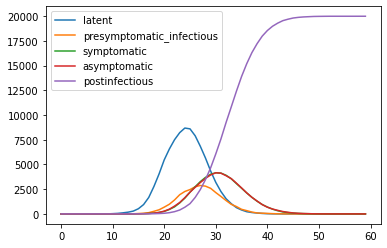

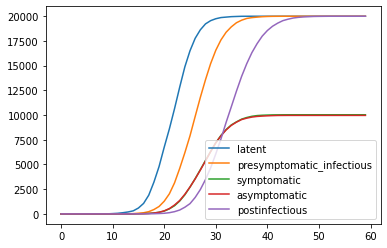

In [7]:
def split_symptomatic_asymptomatic(population_df):
    population_df['t_symptomatic'] = np.NaN
    population_df.loc[population_df.is_symptomatic, 't_symptomatic'] = population_df['t_infectious']
    population_df['t_asymptomatic'] = np.NaN
    population_df.loc[~population_df.is_symptomatic, 't_asymptomatic'] = population_df['t_infectious']
    return(population_df)

def time_compartment_count(population_df, compartment, t, next_compartments=[], cumulative=False):
    col = 't_' + compartment
    compartment_population = population_df[col] <= t
    if (not cumulative) and (len(next_compartments) > 0):
        next_cols = ['t_' + next_c for next_c in next_compartments]
        for next_col in next_cols:
            compartment_population = compartment_population & list(population_df[next_col] > t)
    count = np.sum(compartment_population)
    return count
    

def create_time_df(population_df, days):
    population_df = split_symptomatic_asymptomatic(population_df)
    compartments = ['latent', 'presymptomatic_infectious', 'symptomatic', 'asymptomatic', 'postinfectious']
    next_compartments = {'latent': ['presymptomatic_infectious'], 
                         'presymptomatic_infectious': ['infectious'], 
                         'symptomatic': ['postinfectious'], 
                         'asymptomatic': ['postinfectious'], 
                         'postinfectious': []}
    time_df = pd.DataFrame(columns=compartments)
    for t in range(days):
        for c in compartments:
            time_df.loc[t, c] = time_compartment_count(population_df, c, t, next_compartments[c])
    return time_df
    
def create_cumulative_time_df(population_df, days):
    population_df = split_symptomatic_asymptomatic(population_df)
    compartments = ['latent', 'presymptomatic_infectious', 'symptomatic', 'asymptomatic', 'postinfectious']
    time_df = pd.DataFrame(columns=compartments)
    for t in range(days):
        for c in compartments:
            time_df.loc[t, c] = time_compartment_count(population_df, c, t, cumulative=True)
    return time_df

create_time_df(population_df, days).plot()
plt.show()
create_cumulative_time_df(population_df, days).plot()
plt.show()